# Определение возраста покупателей

**Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей в прикассовой зоне.<br> Это позволит определять возраст клиентов с целью:**

 - Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
 - Контролировать добросовестность кассиров при продаже алкоголя.

# План проекта

1. Проведем исследовательский анализ набора фотографий
2. Подготовим данные к обучению, обучим нейронную сеть и рассчитаем ее качество
3. Проанализируем обученную модель и ее результаты

## Исследовательский анализ данных

Загрузим необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

Загрузим данные

In [3]:
df = pd.read_csv(df_path)

In [4]:
datagen = ImageDataGenerator(rescale=1./255)

In [5]:
data_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=image_directory,
    x_col='file_name',
    y_col='real_age',
    batch_size=32,
    seed=1,
    shuffle=True,
    class_mode='raw',
    target_size=(224, 224)
)

Found 7591 validated image filenames.


Выведем размер выборки

In [6]:
df.shape

(7591, 2)

Визуализируем распределение возраста в выборке

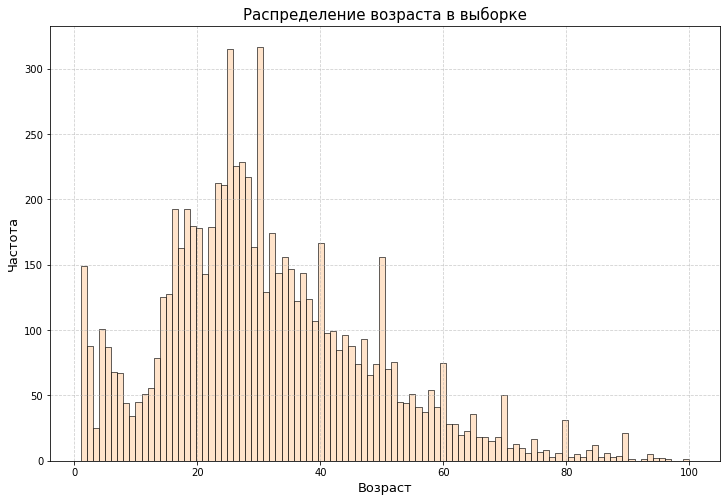

In [7]:
plt.figure(figsize=(12, 8))
sns.histplot(df['real_age'], bins=100, color='peachpuff')
plt.grid(True, linestyle='--', alpha=0.6)
plt.title('Распределение возраста в выборке', size=15)
plt.xlabel('Возраст', size=13)
plt.ylabel('Частота', size=13);

In [8]:
df['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

In [9]:
batch=next(data_generator)
images, labels = batch

In [10]:
num_images = 16

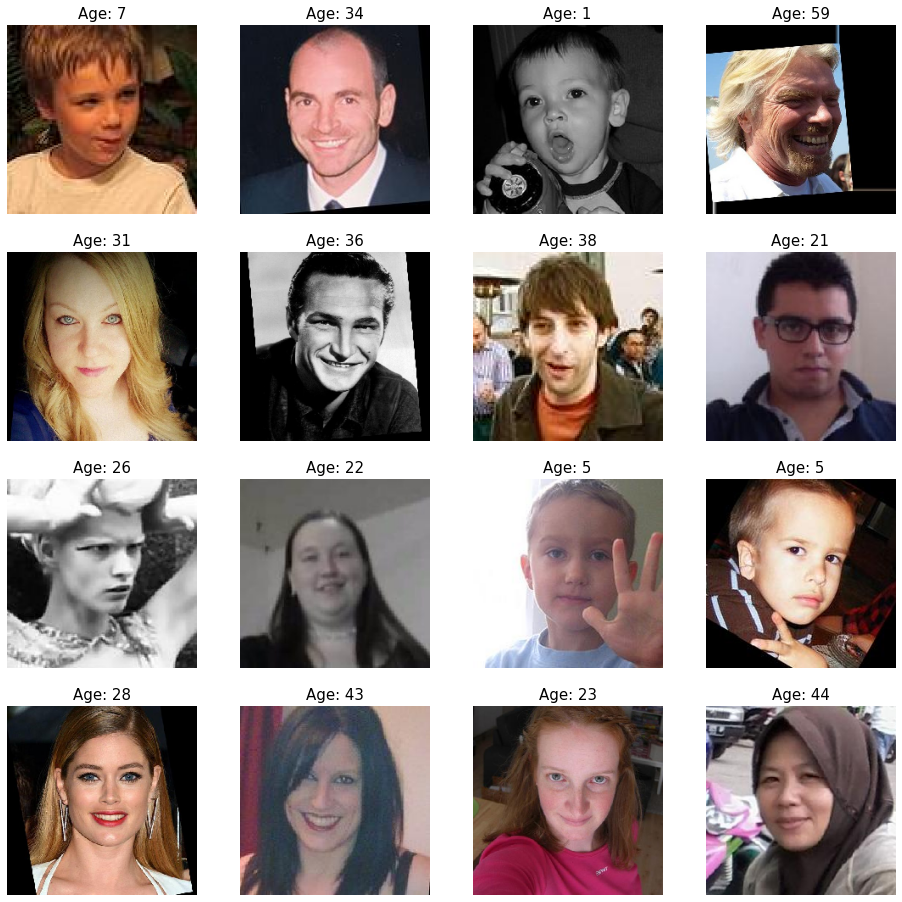

In [11]:
plt.figure(figsize=(16, 16))
for i in range(num_images):
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i])
    plt.title(f'Age: {labels[i]}', size=15)
    plt.axis('off')

### Промежуточный вывод

1. Распределение по возрасту неравномерно, половина всех фотографий с людьми от 20 до 41
2. Имеются фотографии низкого качестве, а также фотографии на которых не видно лица
Все это может осложнить обучение модели

## Обучение модели

Код обучения модели

```python
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from sklearn.model_selection import train_test_split
df = pd.read_csv('/datasets/faces/labels.csv')


train_datagen = ImageDataGenerator(
    rescale=1./255,
    vertical_flip=True,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=90,
    zoom_range=0.2,
    brightness_range=[0.5, 1.5],
    shear_range=0.2,
    validation_split=0.25)

test_datagetn = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.25)

def load_train(path):
    train_data_generator = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory=path +'/final_files',
        x_col='file_name',
        y_col='real_age',
        batch_size=32,
        seed=1,
        shuffle=True,
        class_mode='raw',
        target_size=(224, 224),
        subset='training')
    return train_data_generator
    
def load_test(path):
    test_data_generator = test_datagetn.flow_from_dataframe(
        dataframe=df,
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        batch_size=32,
        seed=1,
        shuffle=True,
        class_mode='raw',
        target_size=(224, 224),
        subset='validation')
    return test_data_generator
    
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='linear'))  
    
    model.compile(optimizer=Adam(lr=0.00005) , loss='mean_squared_error', 
              metrics=['mae']) 

    return model 
    
def train_model(model, train_data, test_data, batch_size=None, epochs=15,
               steps_per_epoch=None, validation_steps=None):
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              verbose=2, shuffle=True, steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps)

    return model 

```

Результаты работы модели

```

Found 5694 validated image filenames.

Found 1897 validated image filenames.

Train for 178 steps, validate for 60 steps

Epoch 1/15

178/178 - 134s - loss: 434.2260 - mae: 15.8691 - val_loss: 848.0722 - val_mae: 24.3002

Epoch 2/15

178/178 - 127s - loss: 156.8783 - mae: 9.5642 - val_loss: 866.0237 - val_mae: 24.5846

Epoch 3/15

178/178 - 126s - loss: 137.0421 - mae: 8.9324 - val_loss: 483.4856 - val_mae: 16.9751

Epoch 4/15

178/178 - 127s - loss: 123.7217 - mae: 8.5034 - val_loss: 202.5674 - val_mae: 10.9643

Epoch 5/15

178/178 - 126s - loss: 115.2440 - mae: 8.1753 - val_loss: 117.5628 - val_mae: 8.3902

Epoch 6/15

178/178 - 127s - loss: 110.3178 - mae: 7.9677 - val_loss: 124.4228 - val_mae: 8.5116

Epoch 7/15

178/178 - 126s - loss: 102.5305 - mae: 7.7622 - val_loss: 124.2557 - val_mae: 8.8416

Epoch 8/15

178/178 - 127s - loss: 96.3112 - mae: 7.5187 - val_loss: 94.4408 - val_mae: 7.3623

Epoch 9/15

178/178 - 127s - loss: 92.3556 - mae: 7.3892 - val_loss: 112.3858 - val_mae: 8.1153

Epoch 10/15

178/178 - 129s - loss: 91.3933 - mae: 7.2576 - val_loss: 140.1306 - val_mae: 8.9023

Epoch 11/15

178/178 - 126s - loss: 82.7190 - mae: 7.0018 - val_loss: 107.7122 - val_mae: 7.7174

Epoch 12/15

178/178 - 126s - loss: 78.9393 - mae: 6.7992 - val_loss: 118.2113 - val_mae: 8.0922

Epoch 13/15

178/178 - 126s - loss: 81.5827 - mae: 6.8473 - val_loss: 93.1454 - val_mae: 7.1401

Epoch 14/15

178/178 - 127s - loss: 72.4198 - mae: 6.5432 - val_loss: 115.3456 - val_mae: 7.9416

Epoch 15/15

178/178 - 126s - loss: 72.8421 - mae: 6.5185 - val_loss: 92.6713 - val_mae: 7.1121

60/60 - 32s - loss: 88.6451 - mae: 7.0006

Test MAE: 7.0006


```

## Анализ обученной модели

Мы загрузили предобученную модель `ResNet50` в качестве основны (backbone) и добавили к ней два слоя: 
 - `GlobalAveragePooling2D` усредняющий информацию по всему изображению
 - `Dense` - полносвязный слой с 1 нейроном с линейной активацией для задачи регрессии

Для оптимизации мы использовали алгоритм `Adam` с `learning rate` **0.00005**

В качестве функции потерь мы использовали `MSE`, а в качестве метрики - `MAE`

Значение `MAE` на тестовом наборе составляет 7.0006, что может быть приемлемым для определения возрастной группы клиента и последующего формирования персональных предложений. Однако, для контроля добросовестности кассиров при продаже алкоголя точность явно недостаточна. Применение нашей модели для этой цели чревато большим количеством ошибок. Можно предположить, что лучшим решением будет обучить отдельную модель классификации, подтверждающую совершеннолетие покупателя. Также, помимо анализа лица, стоит попробовать использовать дополнительные признаки, такие как пол и рост для повышения точности. 

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы